In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
import nltk
import csv
import string
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import transformers
import warnings
import operator
import os
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import gensim

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torchtext import data
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from sklearn.metrics import jaccard_score
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from gensim import utils
from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from scipy.special import softmax

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/tmp/ipykernel_157595/1901597342.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
from roberta_new import RoBERTaCustom

In [4]:
%matplotlib inline
pd.options.display.max_colwidth = 250
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/slava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base') 
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())
        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,  # Add special tokens for RoBERTa
            max_length=self.max_len,
            padding='max_length',  # Pad to max_length
            return_token_type_ids=True,
            return_tensors='pt',  # Return PyTorch tensors
            truncation=True  # Truncate sequences longer than max_length
        )
        input_ids = inputs['input_ids'].squeeze(0)  # Remove the added batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)  # Remove the added batch dimension
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [7]:
model = RoBERTaCustom(num_classes=10)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [8]:
roberta = torch.load("models/roberta-finetuned.pth")
roberta

RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [9]:
torch.save(model.state_dict(), 'models/roberta_weights_only.pth')

In [10]:
model_new = RoBERTaCustom()
model_new.to(device)
model_new.load_state_dict(torch.load('models/roberta_weights_only.pth'))
model_new

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [11]:
def test():
    roberta.eval()
    roberta_outputs = []
    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            outputs = roberta(input_ids=input_ids, attention_mask=attention_mask)
            roberta_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return roberta_outputs

In [12]:
texts_path = '../Georgian Texts/Vazha Pshavela/'
sources = ['en/', 'ggl/', 'gem/', 'gpt/']
prose_path = texts_path + 'Prose/revised/'
prose_names = []

ge_prose_directory = os.fsencode(prose_path + 'ge/')
for file in sorted(os.listdir(ge_prose_directory)):
    prose_names.append(file.decode())

In [14]:
for source in sources:
    for prose in prose_names:
        prose_text = [line.strip() for line in open(prose_path + source + prose, "r")]
        prose_df = pd.DataFrame(prose_text, columns=['Tweet'])
        prose_df['list'] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(prose_text)

        test_dataset = CustomDataset(prose_df, tokenizer, MAX_LEN)
        roberta_test_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
        test_loader = DataLoader(test_dataset, **roberta_test_params)
        test_outputs = test()
        test_outputs = np.array(test_outputs)

        for i in range(test_outputs.shape[0]):
            for j in range(test_outputs.shape[1]):
                if test_outputs[i][j] >= 0.5:
                    test_outputs[i][j] = 1
                else:
                    test_outputs[i][j] = 0

        prose_df['Optimistic'] = "None"
        prose_df['Thankful'] = "None"
        prose_df['Empathetic'] = "None"
        prose_df['Pessimistic'] = "None"
        prose_df['Anxious'] = "None"
        prose_df['Sad'] = "None"
        prose_df['Annoyed'] = "None"
        prose_df['Denial'] = "None"
        prose_df['Official report'] = "None"
        prose_df['Joking'] = "None"
        prose_df = prose_df.drop(['list'], axis=1)

        for i in range(len(test_outputs)):
            prose_df['Optimistic'].iloc[i] = test_outputs[i][0]
            prose_df['Thankful'].iloc[i] = test_outputs[i][1]
            prose_df['Empathetic'].iloc[i] = test_outputs[i][2]
            prose_df['Pessimistic'].iloc[i] = test_outputs[i][3]
            prose_df['Anxious'].iloc[i] = test_outputs[i][4]
            prose_df['Sad'].iloc[i] = test_outputs[i][5]
            prose_df['Annoyed'].iloc[i] = test_outputs[i][6]
            prose_df['Denial'].iloc[i] = test_outputs[i][7]
            prose_df['Official report'].iloc[i] = test_outputs[i][8]
            prose_df['Joking'].iloc[i] = test_outputs[i][9]

        prose_df.to_csv('results/prose/sentiment/' + source + prose)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

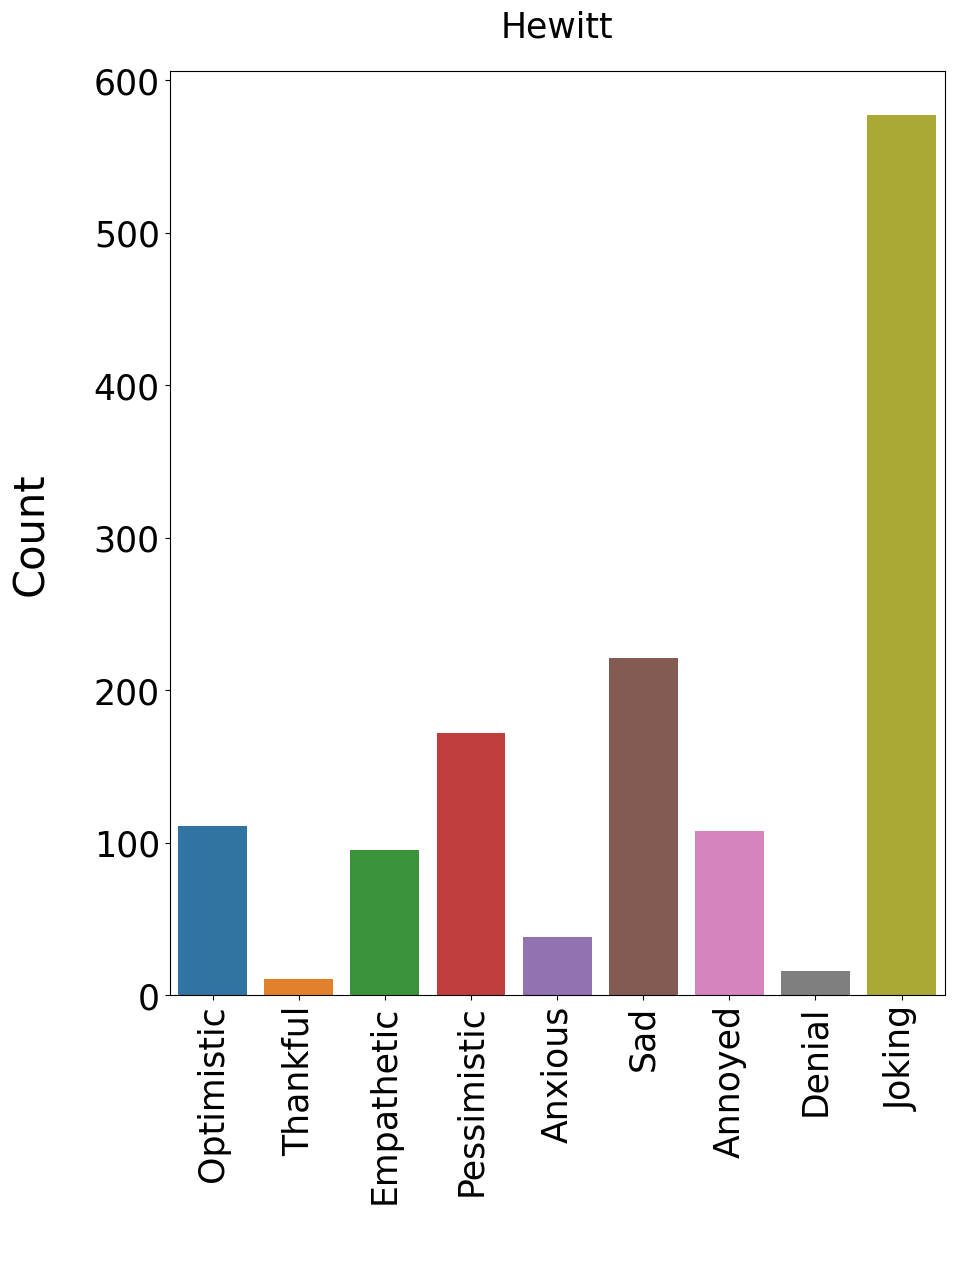

In [29]:
total_df = pd.DataFrame()
for prose in prose_names:
    df = pd.read_csv('results/prose/sentiment/' + 'en/' + prose)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)    

    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    total_df = pd.concat([total_df, df])

total_df = total_df.reset_index()
total_df = total_df.rename(columns={"index": "Sentiment"})

new_df = pd.DataFrame({
    "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
    "Count":[0,0,0,0,0,0,0,0,0,]
})


for ii in range(0, 9):
    for jj in range(0, 12):
        new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)

fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x=new_df.Sentiment, y=new_df.Count, ax=ax, palette=sns.color_palette("tab10"))
plt.xticks(rotation=90)
plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
plt.title('Hewitt', fontsize=25, pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

In [30]:
def all_chapter_dataframe(source):
    total_df = pd.DataFrame()
    for prose in prose_names:
        df = pd.read_csv('results/prose/sentiment/' + source + prose)
        df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
        df = df.apply(pd.Series.value_counts)

        df['Optimistic'] = df['Optimistic'].fillna(0)
        df['Thankful'] = df['Thankful'].fillna(0)
        df['Empathetic'] = df['Empathetic'].fillna(0)
        df['Pessimistic'] = df['Pessimistic'].fillna(0)
        df['Anxious'] = df['Anxious'].fillna(0)
        df['Sad'] = df['Sad'].fillna(0)
        df['Annoyed'] = df['Annoyed'].fillna(0)
        df['Denial'] = df['Denial'].fillna(0)
        df['Joking'] = df['Joking'].fillna(0)    

        df = df.iloc[1]
        df = pd.DataFrame(df)
        df.columns = ['Count']
        total_df = pd.concat([total_df, df])

    total_df = total_df.reset_index()
    total_df = total_df.rename(columns={"index": "Sentiment"})

    new_df = pd.DataFrame({
        "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
        "Count":[0,0,0,0,0,0,0,0,0,]
    })

    for ii in range(0, 9):
        for jj in range(0, 12):
            new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)
    
    return new_df

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

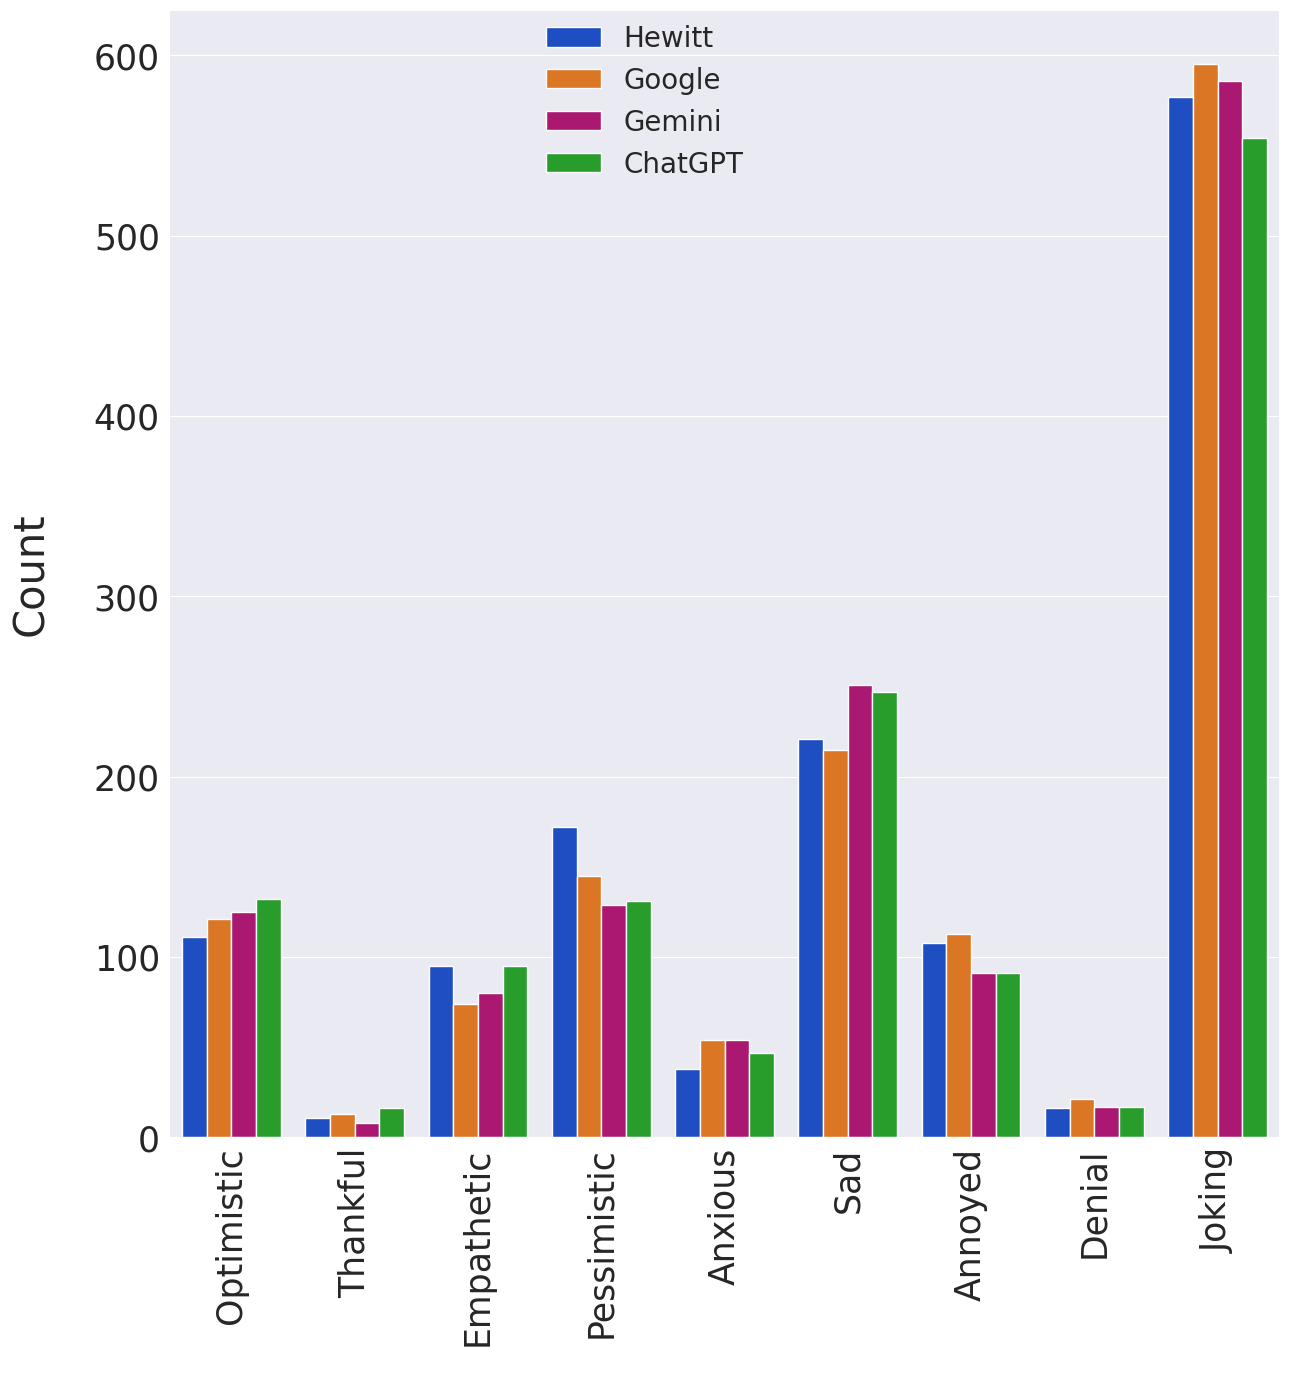

In [31]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')

df_new = pd.concat(
    [
        hewitt_sentiment, 
        google_sentiment['Count'], 
        gemini_sentiment['Count'], 
        chatgpt_sentiment['Count']
    ],
    axis=1
)

df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'ChatGPT']
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
colors = ["blue", "orange", "magenta", "green"]  
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.catplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette=myPalette, legend=True)
g.despine(left=True)
sns.move_legend(g, 'upper center', prop={"size": 20}, title='')
plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)

In [32]:
def chapter_wise_dataframe(source, prose):
    df = pd.read_csv('results/prose/sentiment/' + source + prose)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)
    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)
    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    return df

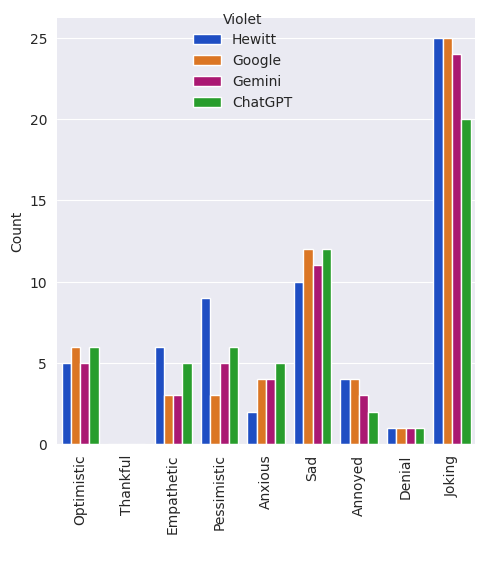

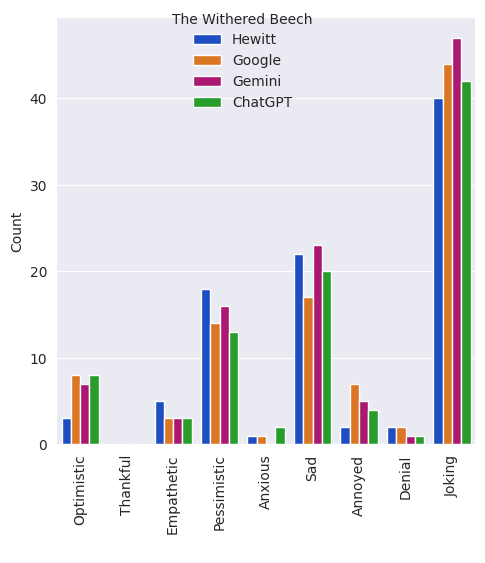

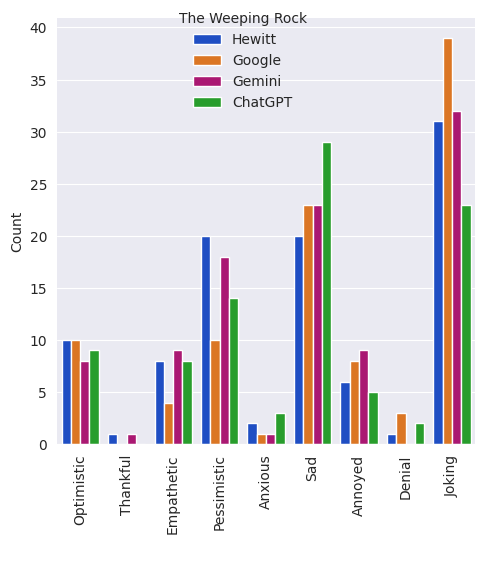

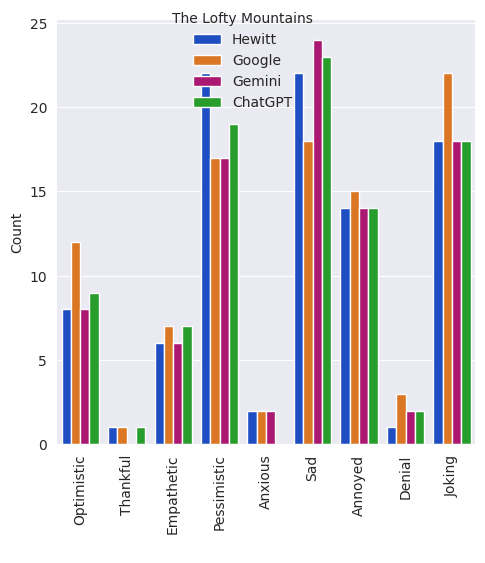

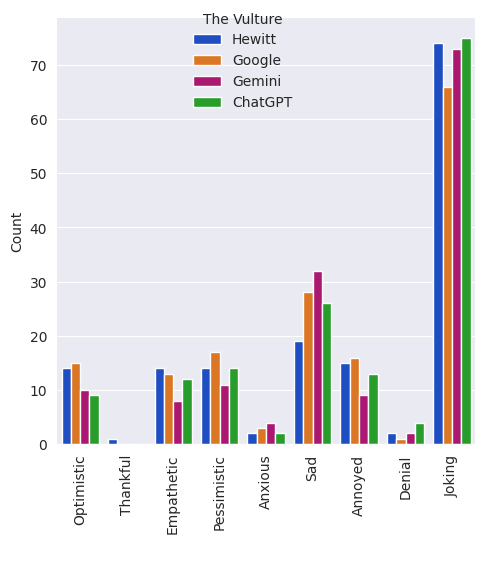

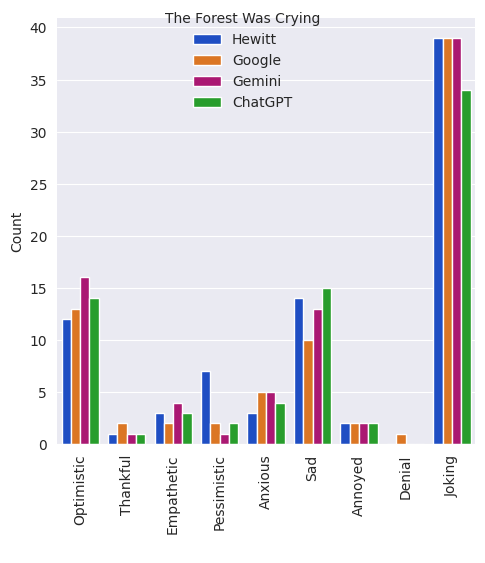

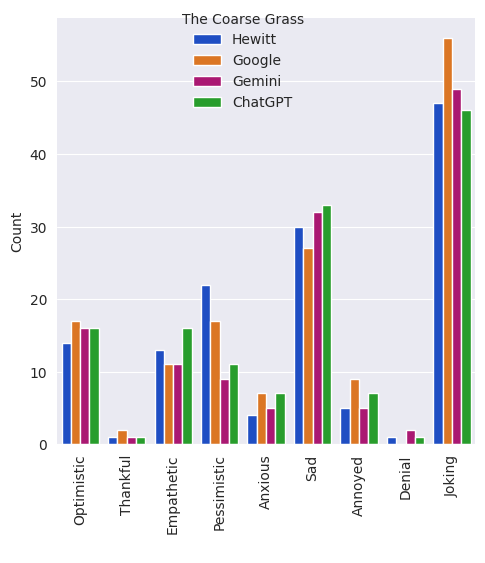

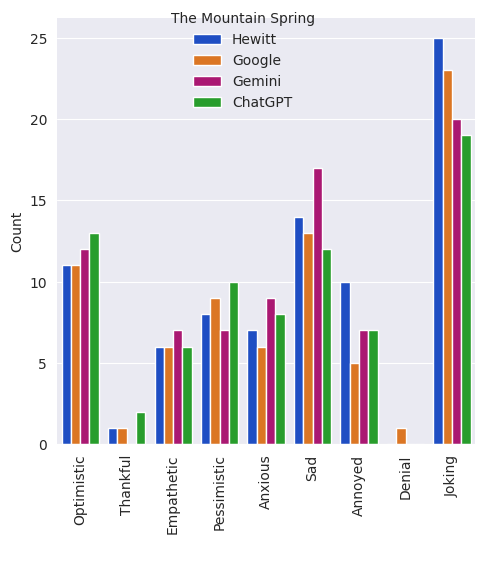

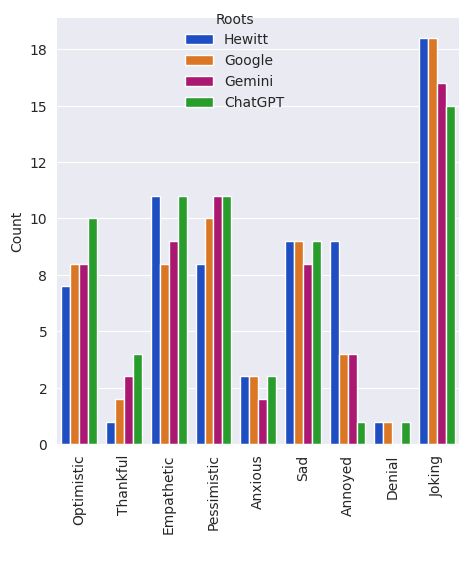

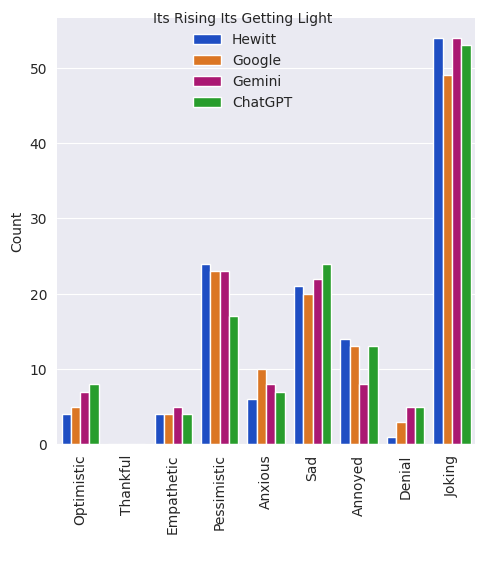

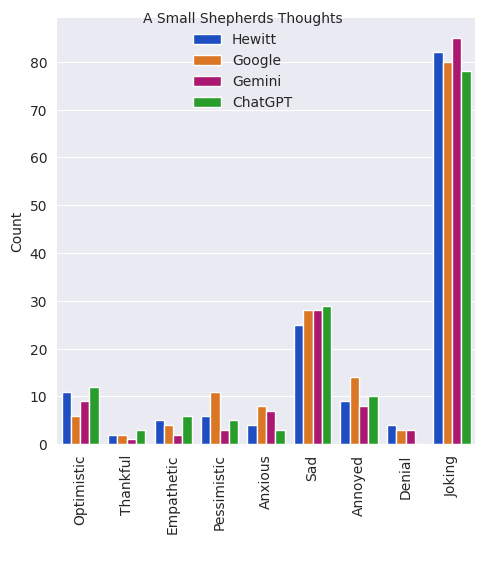

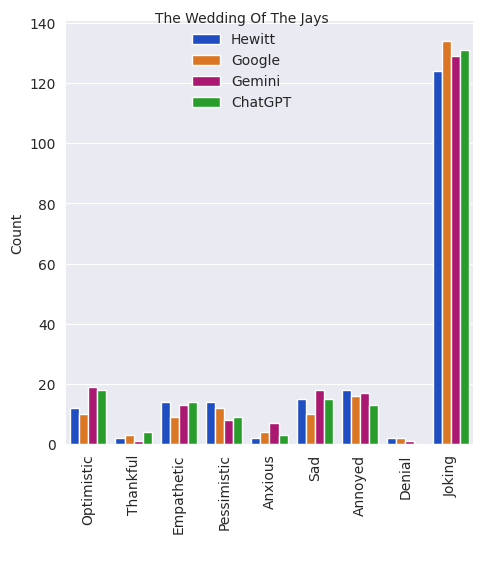

In [33]:
for prose in prose_names:
    hewitt_df = chapter_wise_dataframe('en/', prose)
    google_df = chapter_wise_dataframe('ggl/', prose)
    gemini_df = chapter_wise_dataframe('gem/', prose)
    chatgpt_df =chapter_wise_dataframe('gpt/', prose)
    df_new = pd.concat(
        [
            hewitt_df, 
            google_df['Count'], 
            gemini_df['Count'], 
            chatgpt_df['Count']
        ], 
        axis=1
    )

    df_new.columns = ['Hewitt', 'Google', 'Gemini', 'ChatGPT']
    df_new = df_new.reset_index()
    df_new = df_new.rename(columns={"index":"Sentiment"})
    df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
    colors = ["blue", "orange", "magenta", "green"]  
    myPalette = sns.xkcd_palette(colors)

    sns.set_style("darkgrid")
    g = sns.catplot(
        x='Sentiment', 
        y='Count', 
        hue='Author', 
        data=df_new, 
        kind='bar', 
        palette=myPalette, 
        legend=True
    )
    g.despine(left=True)

    sns.move_legend(g, 'upper center', title=prose[3:-3].replace('_', ' ').title())    
    plt.ylabel('Count')
    plt.xlabel(' ')
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.yticks()
    plt.xticks()
    plt.xticks(rotation=90)

In [34]:
df_new.head()

Sentiment  Author  Count
0   Optimistic  Hewitt   12.0
1     Thankful  Hewitt    2.0
2   Empathetic  Hewitt   14.0
3  Pessimistic  Hewitt   14.0
4      Anxious  Hewitt    2.0

In [35]:
df_new.reset_index()

index    Sentiment   Author  Count
0       0   Optimistic   Hewitt   12.0
1       1     Thankful   Hewitt    2.0
2       2   Empathetic   Hewitt   14.0
3       3  Pessimistic   Hewitt   14.0
4       4      Anxious   Hewitt    2.0
5       5          Sad   Hewitt   15.0
6       6      Annoyed   Hewitt   18.0
7       7       Denial   Hewitt    2.0
8       8       Joking   Hewitt  124.0
9       9   Optimistic   Google   10.0
10     10     Thankful   Google    3.0
11     11   Empathetic   Google    9.0
12     12  Pessimistic   Google   12.0
13     13      Anxious   Google    4.0
14     14          Sad   Google   10.0
15     15      Annoyed   Google   16.0
16     16       Denial   Google    2.0
17     17       Joking   Google  134.0
18     18   Optimistic   Gemini   19.0
19     19     Thankful   Gemini    1.0
20     20   Empathetic   Gemini   13.0
21     21  Pessimistic   Gemini    8.0
22     22      Anxious   Gemini    7.0
23     23          Sad   Gemini   18.0
24     24      Annoyed   Gemini   17.0
25     25       Denial   Gemini    1.0
26     26       Joking   Gemini  129.0
27     27   Optimistic  ChatGPT   18.0
28     28     Thankful  ChatGPT    4.0
29     29   Empathetic  ChatGPT   14.0
30     30  Pessimistic  ChatGPT    9.0
31     31      Anxious  ChatGPT    3.0
32     32          Sad  ChatGPT   15.0
33     33      Annoyed  ChatGPT   13.0
34     34       Denial  ChatGPT    0.0
35     35       Joking  ChatGPT  131.0

<Axes: >

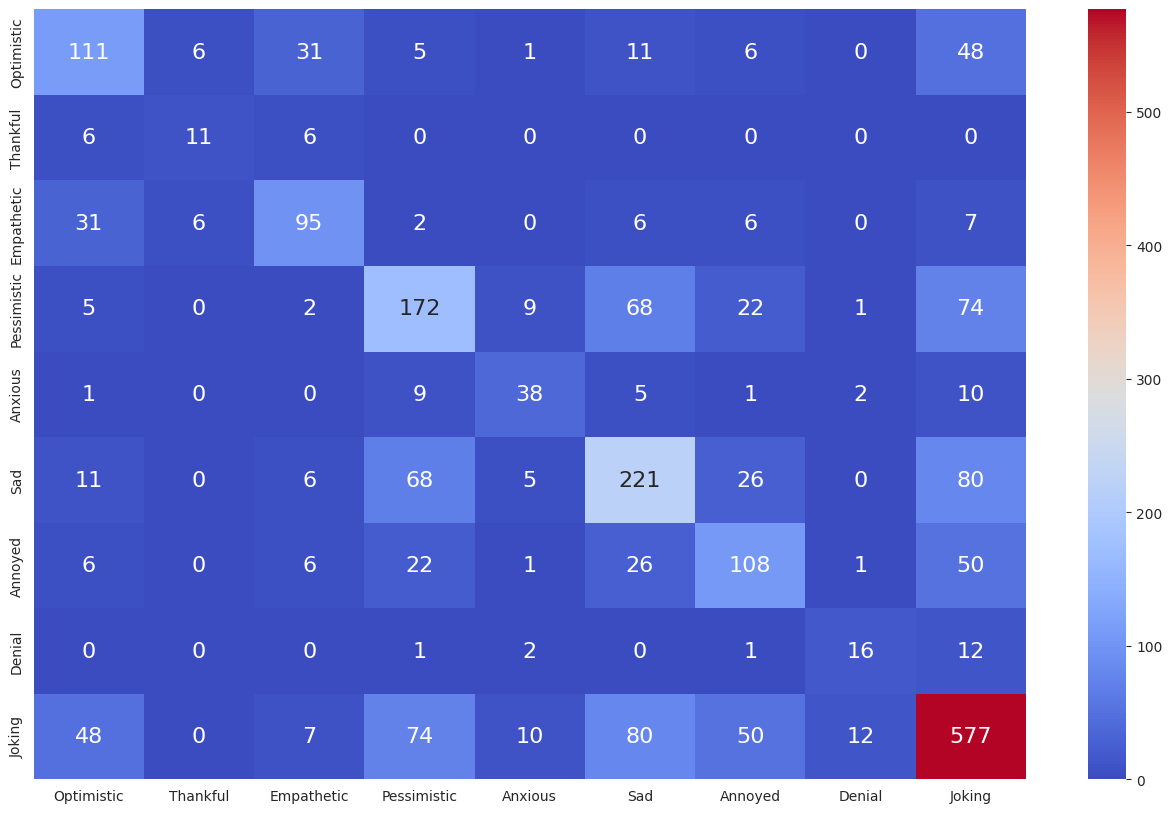

In [36]:
heatmap_df = pd.read_csv('results/prose/sentiment/en/' + prose_names[0])
heatmap_df = heatmap_df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)

for prose in prose_names[1:]:
  df = pd.read_csv('results/prose/sentiment/en/' + prose)
  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((9, 9))
e2i = {'Optimistic': 0, 'Thankful': 1, 'Empathetic': 2, 'Pessimistic': 3, 'Anxious': 4, 'Sad': 5, 'Annoyed': 6, 'Denial': 7, 'Joking': 8}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(9):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 9):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']
emote_df = pd.DataFrame(emote_array, columns=emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.heatmap(emote_df, annot=True, cmap='coolwarm', xticklabels=emote_df.columns, yticklabels=emote_df.columns, fmt='g', annot_kws={"size": 16})

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

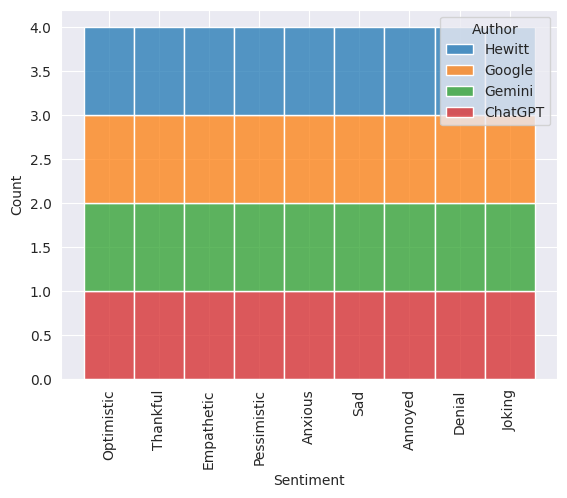

In [37]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')

df_new = pd.concat([
        hewitt_sentiment, 
        google_sentiment['Count'], 
        gemini_sentiment['Count'], 
        chatgpt_sentiment['Count']
    ], 
    axis=1
)
df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'ChatGPT'] 
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
sns.histplot(data=df_new, x='Sentiment', hue='Author', multiple='stack')
plt.xticks(rotation=90)

In [38]:
df_new.head()

Sentiment  Author  Count
0   Optimistic  Hewitt    111
1     Thankful  Hewitt     11
2   Empathetic  Hewitt     95
3  Pessimistic  Hewitt    172
4      Anxious  Hewitt     38

In [40]:
hewitt_prose_01 = pd.read_csv('results/prose/sentiment/en/' + prose_names[0])
google_prose_01 = pd.read_csv('results/prose/sentiment/ggl/' + prose_names[0])
gemini_prose_01 = pd.read_csv('results/prose/sentiment/gem/' + prose_names[0])
chatgpt_prose_01 = pd.read_csv('results/prose/sentiment/gpt/' + prose_names[0])

hewitt_prose_01_short = hewitt_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
google_prose_01_short = google_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
gemini_prose_01_short = gemini_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
chatgpt_prose_01_short = chatgpt_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

In [41]:
hewitt_prose_01

Unnamed: 0  \
0            0   
1            1   
2            2   
3            3   
4            4   
5            5   
6            6   
7            7   
8            8   
9            9   
10          10   
11          11   
12          12   
13          13   
14          14   
15          15   
16          16   
17          17   
18          18   
19          19   
20          20   
21          21   
22          22   
23          23   
24          24   
25          25   
26          26   
27          27   
28          28   
29          29   
30          30   
31          31   
32          32   
33          33   
34          34   
35          35   
36          36   

                                                                                                                                                                                                                                                        Tweet  \
0                                                                                                                                                                                                                    I have sprung to life in a dense forest…   
1                                          While I live, with my beauty I shall bring sweetness to the forest, the grass and that rock which gazes over from across the river, with its bosom clothed in moss; I shall spread my delightful aroma all around.   
2   I am loved by all; just here that rotting tree-stump has its eye constantly fixed on me; it laughs in my direction and wants to come over — to kiss me, but it can’t; only from a distance will it continue to laugh and smile at me, poor thing; it m...   
3                                                                                                                                                                                       And do you think it’s only that stump which rejoices in my existence?   
4                                 The trees too with their dry, beard-like foliage joyfully look down on me from above — themselves bare-headed, they cover me with their branches: “Our little violet mustn’t catch cold; nothing must upset her,” they say.   
5                                                                                                                                           The cascading rain they don’t allow to fall directly upon me, for in a moment the rain can strip me of my leaves,   
6                                                                                                                                                                                                                        And leaflessness means death for me.   
7         No, the trees — birch, beech, the nut, wild pear and elder guard me on all sides; droplets of rain on their branches they hold and then slowly sprinkle on my face, just two or three, to produce a dew-like effect, and thus bathe my face for me.   
8   I gracefully bend my neck and yearn that I could only sing and that he who gave me life had endowed me with the talent to praise on high the sky and clouds, the sun, these trees that protect me, these mountains, those groves and fluffy-chested bi...   
9                                                                                                                                   My single month’s existence betters another’s two-year span; nevertheless a long life is indeed the object of my desires.   
10  This morning a beech-warbler sang away close by me — it was a thing of beauty, red-necked and fluffy-chested; it too, just like me, took pride in itself as it looked over its breast and shoulders; everything takes pride in itself, everything enjo...   
11                                                                          Yesterday there was thunder in the heavens; but thunder and lightning cause us no fear — thunder portends rain, and rain, after all, gives us suck at the breas

In [42]:
google_prose_01

Unnamed: 0  \
0            0   
1            1   
2            2   
3            3   
4            4   
5            5   
6            6   
7            7   
8            8   
9            9   
10          10   
11          11   
12          12   
13          13   
14          14   
15          15   
16          16   
17          17   
18          18   
19          19   
20          20   
21          21   
22          22   
23          23   
24          24   
25          25   
26          26   
27          27   
28          28   
29          29   
30          30   
31          31   
32          32   
33          33   
34          34   
35          35   
36          36   

                                                                                                                                                                                                                                                        Tweet  \
0                                                                                                                                                                                                                          I have come to the dense forest...   
1                                                                                                                 As long as I am alive, I will sweeten the forest, the grass, and the mossy rock with my beauty, I will sprinkle spices on the surroundings.   
2   Everyone loves me: if that rotten bastard keeps his eyes on me, he laughs at me, he wants to come to me, - kiss me, but he can't, he only laughs at me from afar, he smiles pitifully, although ugly, but the kindness is sometimes reflected on his f...   
3                                                                                                                                                                                                                 Is that the only reason they enjoy my life?   
4                                                                                                    Even the topless trees are leaning on me from above, they themselves are bare, their branches cover me: let not our yew get cold, or let nothing freeze.   
5                                                                                                                                                                            They don't let direct rain fall on me: the rain can wash off the leaves at once.   
6                                                                                                                                                                                                         Being leafless and dying are the same thing for me.   
7                           No, the trees: birch, beech, hazel, tamel, dudgula surround me and make me strong, they keep the rain dew with their branches and leaves and then they slowly sprinkle my mouth with one or two drops of dew, they wash my mouth.   
8   I will sing my throat and miss, I wish I could sing, I wish the creator gave me the talent to have above me the sky and the clouds, the sun, these trees of my protection, these mountains, those marshes and the birds that dry, yellow in the leaves...   
9                                                                                                                                                           My life of one month is better than another's life of twenty-four months, but I miss a long life.   
10                    In the morning, a "beech-cheetah" chirped near me, it was a beautiful thing, red-throated, gabua; Like me, he liked himself, looked at his heart and shoulders; Everyone likes themselves, everyone enjoys life, everyone loves nature.   
11                                                                                                            The sky was thundering yesterday. The thunder does not frighten us: the thunder brings rain, and the rain suckles us at the h

In [43]:
gemini_prose_01

Unnamed: 0  \
0            0   
1            1   
2            2   
3            3   
4            4   
5            5   
6            6   
7            7   
8            8   
9            9   
10          10   
11          11   
12          12   
13          13   
14          14   
15          15   
16          16   
17          17   
18          18   
19          19   
20          20   
21          21   
22          22   
23          23   
24          24   
25          25   
26          26   
27          27   
28          28   
29          29   
30          30   
31          31   
32          32   
33          33   
34          34   
35          35   
36          36   

                                                                                                                                                                                                                                                        Tweet  \
0                                                                                                                                                                                                                            I have come to a dense forest...   
1                                                                                             As long as I am alive, I will delight the forest, the grass, and that heart-shaped rock looking at me from afar with my beauty, I will spread fragrance around.   
2   Everyone loves me: that rotten stump over there has its eyes fixed on me, it smiles at me sometimes, it wants to come to me - to kiss me, but it can't, it just smiles at me from afar, the poor thing will smile, even though it's ugly, but great ki...   
3                                                                                                                                                                                                                   Is it only him who is happy with my life?   
4                                                                                       The bearded trees also lean towards me from above, themselves bareheaded, they cover me with their branches: Let our violet not catch a cold, or let nothing hurt it.   
5                                                                                                                                                                      They don't let the direct shower rain reach me: the rain can suddenly strip my leaves.   
6                                                                                                                                                                                                               Being leafless and death are the same for me.   
7                                             No, the trees: birch, beech, hazel, elm, hornbeam surround me and guard me, they keep the rain dew with their branches, leaves, and then slowly sprinkle one or two drops of dew on my face, they wash my face.   
8   I stretch my neck and wish, if only I could sing, if only the creator had given me the talent, so that I could sing the high sky and clouds, the sun, these trees that protect me, these mountains, those meadows and colorful birds, which are black,...   
9                                                                                                                                                  My one month of life is better than twenty-four months of someone else's life, but I long for a long life.   
10        In the morning, a "beech bird" sang near me, it was a beautiful thing - red-throated, colorful; he also liked himself like me, he looked at his heart and shoulders; Everyone likes themselves, everyone is happy with life, everyone loves nature.   
11                                                                                                                    Yesterday the sky thundered. Thunder does not scare us: thunder is a harbinger of rain, and rain suckles us on the br

In [44]:
chatgpt_prose_01

Unnamed: 0  \
0            0   
1            1   
2            2   
3            3   
4            4   
5            5   
6            6   
7            7   
8            8   
9            9   
10          10   
11          11   
12          12   
13          13   
14          14   
15          15   
16          16   
17          17   
18          18   
19          19   
20          20   
21          21   
22          22   
23          23   
24          24   
25          25   
26          26   
27          27   
28          28   
29          29   
30          30   
31          31   
32          32   
33          33   
34          34   
35          35   
36          36   

                                                                                                                                                                                                                                                        Tweet  \
0                                                                                                                                                                                                                          I have come to the dense forest...   
1                                                                                          As long as I am alive, I will grace the forest, the grass, and that rough cliff watching from afar with my beauty. I will spread my fragrance to the surroundings.   
2   Everyone loves me: look at that rotting stump, its eyes always fixed on me, it smiles sometimes, wanting to come closer, to kiss me, but it cannot; it only smiles at me from a distance, poor thing, though unattractive, a great kindness spreads ov...   
3                                                                                                                                                                                                                  Is it only that which rejoices in my life?   
4                                                                                              Even the dead trees support me from above, themselves bare-headed, they cover me with their branches: "Let our violet not get cold, or be harmed by anything."   
5                                                                                                                                                                   They do not let the heavy rain reach me directly: rain can strip me of my leaves at once.   
6                                                                                                                                                                                                           Being without leaves is the same as death for me.   
7                                                                  No, the trees: birch, beech, hazel, elm, and poplar surround me and guard me, they keep the rain's moisture in their branches and leaves and then slowly drip it onto me, washing my face.   
8   I lift my head and wish, if only I could sing, if only my creator had given me the gift to praise the high sky and clouds, the sun, these protective trees, these mountains, those meadows, and the chirping birds, which with their red and green fea...   
9                                                                                                                                                   My one month's life is better than someone else's twenty-four months of life, but I long for a long life.   
10                  This morning, a "beech-bird" sang near me, it was beautiful – red-throated, chirping; it too, like me, admired itself, looking at its chest and shoulders; everyone admires themselves, everyone rejoices in life, everyone loves nature.   
11                                                                                                                 Yesterday the sky thundered. Thunder and lightning do not frighten us: thunder heralds rain, and rain nurses us on the h

In [45]:
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

In [46]:
for ii in range(0, hewitt_prose_01_short.shape[0]):
    print(jaccard_score(google_prose_01_short.iloc[ii, :], hewitt_prose_01_short.iloc[ii, :]))

0.3333333333333333
1.0
0.5
0.5
0.5
0.3333333333333333
0.5
0.5
0.25
0.0
0.5
0.6666666666666666
1.0
0.6666666666666666
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.5
0.3333333333333333
1.0
0.3333333333333333
1.0
0.0
0.25
0.3333333333333333
1.0
0.0
0.0
0.5


In [48]:
hewitt_ggl_df = pd.DataFrame()
hewitt_gem_df = pd.DataFrame()
hewitt_gpt_df = pd.DataFrame()

prose_list = []
hewitt_ggl_lst = []
hewitt_gem_lst = []
hewitt_gpt_lst = []

ggl = []
gem = []
gpt = []

sum1 = 0
sum2 = 0
sum3 = 0

for prose in prose_names:
    hewitt_df = pd.read_csv('results/prose/sentiment/' + 'en/' + prose)
    google_df = pd.read_csv('results/prose/sentiment/' + 'ggl/' + prose)
    gemini_df = pd.read_csv('results/prose/sentiment/' + 'gem/' + prose)
    chatgpt_df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)

    hewitt_df = hewitt_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    google_df = google_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    gemini_df = gemini_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    chatgpt_df = chatgpt_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

    for ii in range(0, hewitt_df.shape[0]):
        hewitt_ggl_lst.append(jaccard_score(hewitt_df.iloc[ii, :], google_df.iloc[ii, :]))
        hewitt_gem_lst.append(jaccard_score(hewitt_df.iloc[ii, :], gemini_df.iloc[ii, :]))
        hewitt_gpt_lst.append(jaccard_score(hewitt_df.iloc[ii, :], chatgpt_df.iloc[ii, :]))

    prose_list.append(prose)

    hewitt_ggl_df1 = pd.DataFrame(prose_list, columns=['Prose'])
    hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_lst, columns=['Hewitt - Google'])
    hewitt_ggl_df  = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)

    hewitt_gem_df1 = pd.DataFrame(prose_list, columns=['Prose'])
    hewitt_gem_df2 = pd.DataFrame(hewitt_gem_lst, columns=['Hewitt - Gemini'])
    hewitt_gem_df  = pd.concat([hewitt_gem_df1, hewitt_gem_df2], axis=1)

    hewitt_gpt_df1 = pd.DataFrame(prose_list, columns=['Prose'])
    hewitt_gpt_df2 = pd.DataFrame(hewitt_gpt_lst, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df  = pd.concat([hewitt_gpt_df1, hewitt_gpt_df2], axis=1)    

    ggl.append(hewitt_ggl_df['Hewitt - Google'].mean())
    hewitt_ggl_df3 = pd.DataFrame(ggl, columns=['Hewitt - Google'])
    hewitt_ggl_df4 = pd.concat([hewitt_ggl_df1, hewitt_ggl_df3], axis=1)

    gem.append(hewitt_gem_df['Hewitt - Gemini'].mean())
    hewitt_gem_df3 = pd.DataFrame(gem, columns=['Hewitt - Gemini'])
    hewitt_gem_df4 = pd.concat([hewitt_gem_df1, hewitt_gem_df3], axis=1)

    gpt.append(hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    hewitt_gpt_df3 = pd.DataFrame(gpt, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df4 = pd.concat([hewitt_gpt_df1, hewitt_gpt_df3], axis=1)


    print('Prose "', str(prose[3:-3].replace('_', ' ').title()), '" Average')
    print('Hewitt - Google ', hewitt_ggl_df['Hewitt - Google'].mean())
    print('Hewitt - Gemini ', hewitt_gem_df['Hewitt - Gemini'].mean())
    print('Hewitt - ChatGPT ', hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    print('\n')

    sum1 += hewitt_ggl_df['Hewitt - Google'].mean()
    sum2 += hewitt_gem_df['Hewitt - Gemini'].mean()
    sum3 += hewitt_gpt_df['Hewitt - ChatGPT'].mean()

Prose " Violet " Average
Hewitt - Google  0.5945945945945945
Hewitt - Gemini  0.6869369369369369
Hewitt - ChatGPT  0.6013513513513512


Prose " The Withered Beech " Average
Hewitt - Google  0.5916666666666667
Hewitt - Gemini  0.6633333333333333
Hewitt - ChatGPT  0.6591666666666667


Prose " The Weeping Rock " Average
Hewitt - Google  0.5853658536585366
Hewitt - Gemini  0.6158536585365854
Hewitt - ChatGPT  0.6183943089430893


Prose " The Lofty Mountains " Average
Hewitt - Google  0.5551851851851851
Hewitt - Gemini  0.5911111111111111
Hewitt - ChatGPT  0.611851851851852


Prose " The Vulture " Average
Hewitt - Google  0.5866161616161616
Hewitt - Gemini  0.6169191919191919
Hewitt - ChatGPT  0.6214646464646464


Prose " The Forest Was Crying " Average
Hewitt - Google  0.6010498687664042
Hewitt - Gemini  0.6242344706911636
Hewitt - ChatGPT  0.6266404199475065


Prose " The Coarse Grass " Average
Hewitt - Google  0.5991895701198026
Hewitt - Gemini  0.6347780126849895
Hewitt - ChatGPT  0.622

In [49]:
sum1 = sum1 / len(prose_names)
sum2 = sum2 / len(prose_names)
sum3 = sum3 / len(prose_names)

print('sum1 ', sum1)
print('sum2 ', sum2)
print('sum3 ', sum3)

sum1  0.5940491173232207
sum2  0.6381212551434109
sum3  0.626120844602043


In [50]:
hewitt_ggl_df1 = pd.DataFrame(prose_list, columns=['Prose'])
hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_df4, columns=['Hewitt - Google'])
hewitt_ggl_df = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)
hewitt_ggl_df

Prose  Hewitt - Google
0                         21_violet.md         0.594595
1             22_the_withered_beech.md         0.591667
2               23_the_weeping_rock.md         0.585366
3            24_the_lofty_mountains.md         0.555185
4                    25_the_vulture.md         0.586616
5          26_the_forest_was_crying.md         0.601050
6               27_the_coarse_grass.md         0.599190
7            28_the_mountain_spring.md         0.595945
8                          29_roots.md         0.598498
9   30_its_rising_its_getting_light.md         0.593942
10    31_a_small_shepherds_thoughts.md         0.602034
11       32_the_wedding_of_the_jays.md         0.624502

In [51]:
df_final = pd.concat([
        hewitt_ggl_df, 
        hewitt_gem_df3['Hewitt - Gemini'], 
        hewitt_gpt_df3['Hewitt - ChatGPT']
    ], 
    axis=1
)
df_final

Prose  Hewitt - Google  Hewitt - Gemini  \
0                         21_violet.md         0.594595         0.686937   
1             22_the_withered_beech.md         0.591667         0.663333   
2               23_the_weeping_rock.md         0.585366         0.615854   
3            24_the_lofty_mountains.md         0.555185         0.591111   
4                    25_the_vulture.md         0.586616         0.616919   
5          26_the_forest_was_crying.md         0.601050         0.624234   
6               27_the_coarse_grass.md         0.599190         0.634778   
7            28_the_mountain_spring.md         0.595945         0.636015   
8                          29_roots.md         0.598498         0.640901   
9   30_its_rising_its_getting_light.md         0.593942         0.635481   
10    31_a_small_shepherds_thoughts.md         0.602034         0.646763   
11       32_the_wedding_of_the_jays.md         0.624502         0.665128   

    Hewitt - ChatGPT  
0           0.601351  
1           0.659167  
2           0.618394  
3           0.611852  
4           0.621465  
5           0.626640  
6           0.622269  
7           0.620211  
8           0.627415  
9           0.623901  
10          0.633355  
11          0.647430

In [52]:
hewitt_ggl_avg_score = df_final['Hewitt - Google'].mean()
hewitt_gem_avg_score = df_final['Hewitt - Gemini'].mean()
hewitt_gpt_avg_score = df_final['Hewitt - ChatGPT'].mean()

print(hewitt_ggl_avg_score)
print(hewitt_gem_avg_score)
print(hewitt_gpt_avg_score)

0.5940491173232207
0.6381212551434109
0.626120844602043


In [53]:
data = pd.melt(df_final, ['Prose'])
data

Prose          variable     value
0                         21_violet.md   Hewitt - Google  0.594595
1             22_the_withered_beech.md   Hewitt - Google  0.591667
2               23_the_weeping_rock.md   Hewitt - Google  0.585366
3            24_the_lofty_mountains.md   Hewitt - Google  0.555185
4                    25_the_vulture.md   Hewitt - Google  0.586616
5          26_the_forest_was_crying.md   Hewitt - Google  0.601050
6               27_the_coarse_grass.md   Hewitt - Google  0.599190
7            28_the_mountain_spring.md   Hewitt - Google  0.595945
8                          29_roots.md   Hewitt - Google  0.598498
9   30_its_rising_its_getting_light.md   Hewitt - Google  0.593942
10    31_a_small_shepherds_thoughts.md   Hewitt - Google  0.602034
11       32_the_wedding_of_the_jays.md   Hewitt - Google  0.624502
12                        21_violet.md   Hewitt - Gemini  0.686937
13            22_the_withered_beech.md   Hewitt - Gemini  0.663333
14              23_the_weeping_rock.md   Hewitt - Gemini  0.615854
15           24_the_lofty_mountains.md   Hewitt - Gemini  0.591111
16                   25_the_vulture.md   Hewitt - Gemini  0.616919
17         26_the_forest_was_crying.md   Hewitt - Gemini  0.624234
18              27_the_coarse_grass.md   Hewitt - Gemini  0.634778
19           28_the_mountain_spring.md   Hewitt - Gemini  0.636015
20                         29_roots.md   Hewitt - Gemini  0.640901
21  30_its_rising_its_getting_light.md   Hewitt - Gemini  0.635481
22    31_a_small_shepherds_thoughts.md   Hewitt - Gemini  0.646763
23       32_the_wedding_of_the_jays.md   Hewitt - Gemini  0.665128
24                        21_violet.md  Hewitt - ChatGPT  0.601351
25            22_the_withered_beech.md  Hewitt - ChatGPT  0.659167
26              23_the_weeping_rock.md  Hewitt - ChatGPT  0.618394
27           24_the_lofty_mountains.md  Hewitt - ChatGPT  0.611852
28                   25_the_vulture.md  Hewitt - ChatGPT  0.621465
29         26_the_forest_was_crying.md  Hewitt - ChatGPT  0.626640
30              27_the_coarse_grass.md  Hewitt - ChatGPT  0.622269
31           28_the_mountain_spring.md  Hewitt - ChatGPT  0.620211
32                         29_roots.md  Hewitt - ChatGPT  0.627415
33  30_its_rising_its_getting_light.md  Hewitt - ChatGPT  0.623901
34    31_a_small_shepherds_thoughts.md  Hewitt - ChatGPT  0.633355
35       32_the_wedding_of_the_jays.md  Hewitt - ChatGPT  0.647430

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '21_violet.md'),
  Text(1, 0, '22_the_withered_beech.md'),
  Text(2, 0, '23_the_weeping_rock.md'),
  Text(3, 0, '24_the_lofty_mountains.md'),
  Text(4, 0, '25_the_vulture.md'),
  Text(5, 0, '26_the_forest_was_crying.md'),
  Text(6, 0, '27_the_coarse_grass.md'),
  Text(7, 0, '28_the_mountain_spring.md'),
  Text(8, 0, '29_roots.md'),
  Text(9, 0, '30_its_rising_its_getting_light.md'),
  Text(10, 0, '31_a_small_shepherds_thoughts.md'),
  Text(11, 0, '32_the_wedding_of_the_jays.md')])

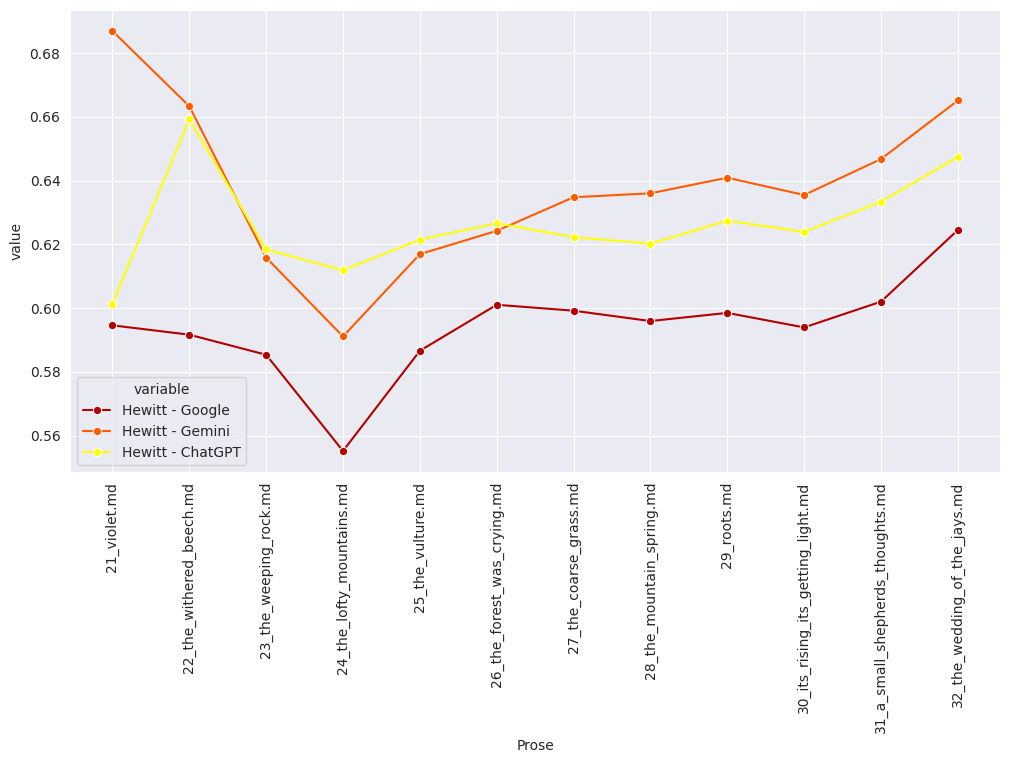

In [54]:
sns.set_style("darkgrid")
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Prose', y='value', hue = 'variable', data=data, palette='hot', dashes=False, marker='o', ax=ax)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '21_violet.md'),
  Text(1, 0, '22_the_withered_beech.md'),
  Text(2, 0, '23_the_weeping_rock.md'),
  Text(3, 0, '24_the_lofty_mountains.md'),
  Text(4, 0, '25_the_vulture.md'),
  Text(5, 0, '26_the_forest_was_crying.md'),
  Text(6, 0, '27_the_coarse_grass.md'),
  Text(7, 0, '28_the_mountain_spring.md'),
  Text(8, 0, '29_roots.md'),
  Text(9, 0, '30_its_rising_its_getting_light.md'),
  Text(10, 0, '31_a_small_shepherds_thoughts.md'),
  Text(11, 0, '32_the_wedding_of_the_jays.md')])

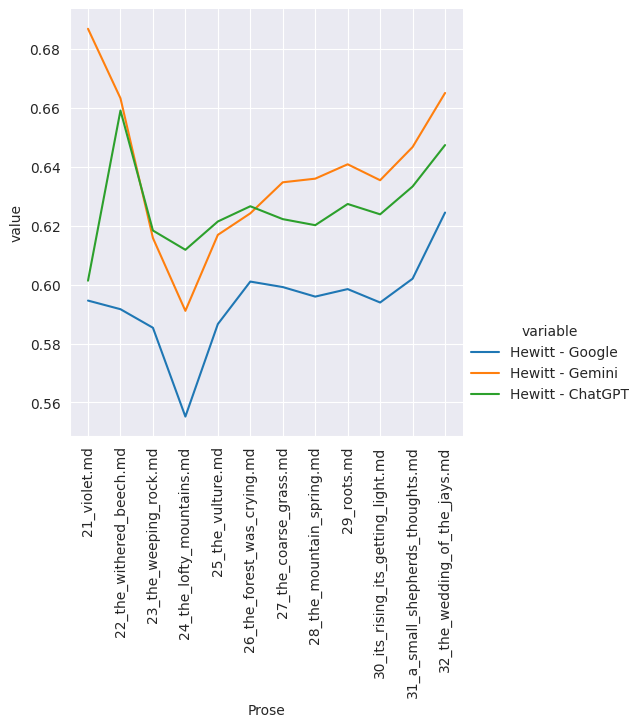

In [55]:
sns.relplot(x="Prose", y="value", hue="variable", dashes=False, markers=True, kind="line", data=data)
plt.xticks(rotation=90)

In [56]:
sentiment_polarity = {
    # 'Surprise': 0,
    'Joking': 0,
    'Pessimistic': -1,
    'Anxious': -1,
    'Sad':  -1,
    'Annoyed': -1,
    'Denial': -1,
    'Optimistic': 1,
    'Thankful': 1,
    'Empathetic': 1
}

In [57]:
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
init_notebook_mode(connected=False)
warnings.filterwarnings("ignore")

In [58]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']

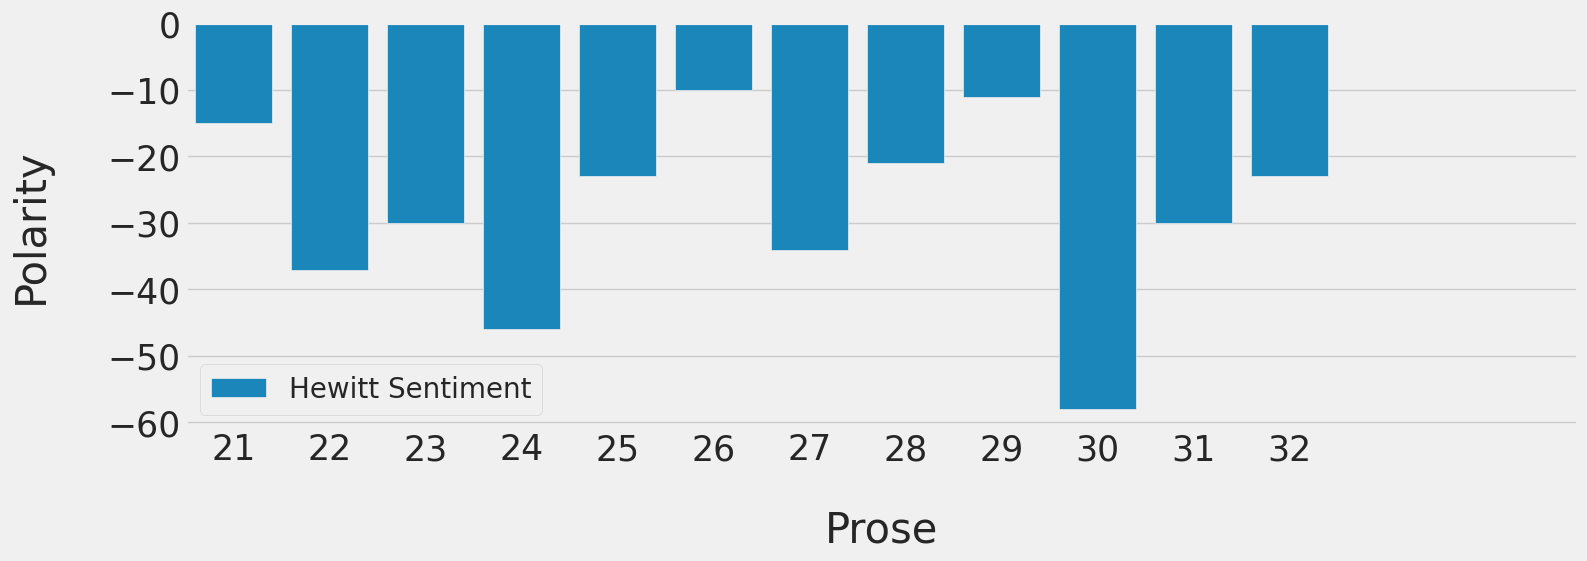

In [59]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Prose', 'Polarity'])

for prose in prose_names:
    df_prose = pd.read_csv('results/prose/sentiment/' + 'en/' + prose)
    polarity = 0
    for i, row in df_prose.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[prose[:2], polarity]], columns = ['Prose', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Prose')
df_sentiments.reset_index()
df_sentiments.set_index('Prose')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 5))
p6 = sns.barplot(x=df_sentiments['Prose'], y=df_sentiments['Polarity'], label='Hewitt Sentiment')
p6.set_xlabel("Hewitt Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Prose', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

In [60]:
def flatten(lst):
    new_list = []
    for sublist in lst:
      if isinstance(sublist, list):
        for item in sublist:
          new_list.append(item)
      else:
        new_list.append(sublist)
    return new_list

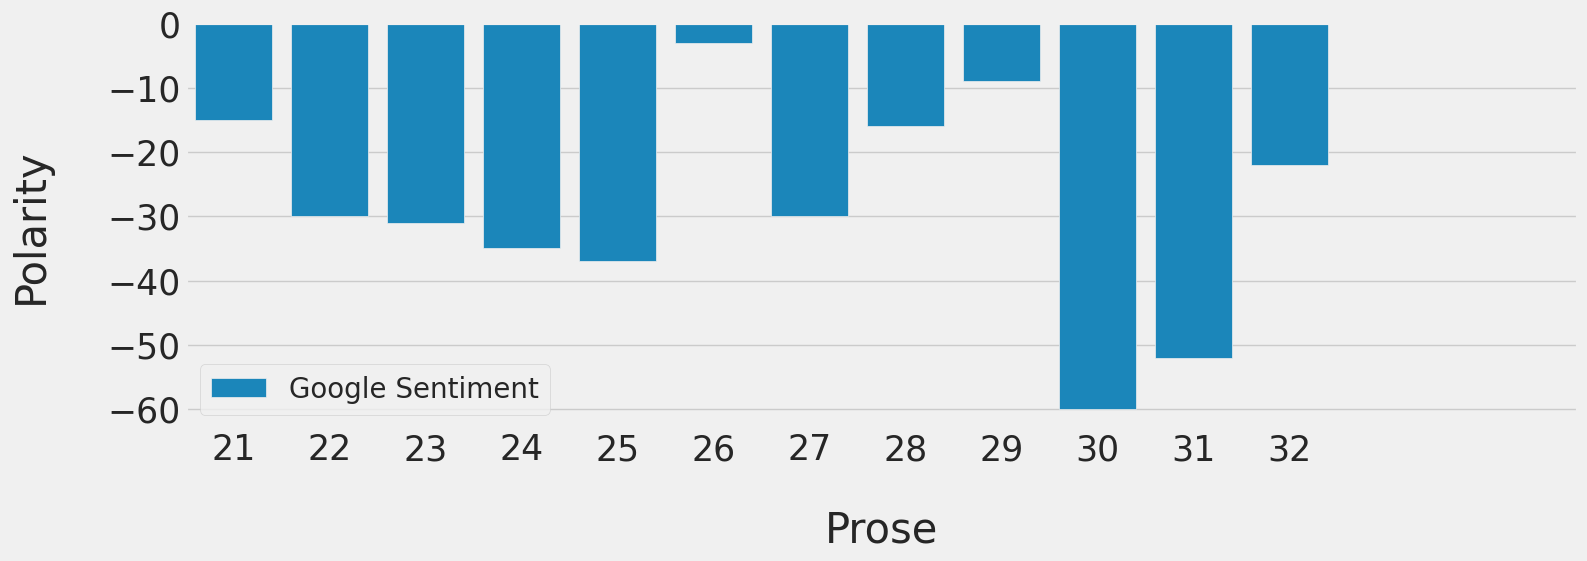

In [61]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Prose', 'Polarity'])

for prose in prose_names:
    df_prose = pd.read_csv('results/prose/sentiment/' + 'ggl/' + prose)
    polarity = 0
    for i, row in df_prose.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[prose[:2], polarity]], columns = ['Prose', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Prose')
df_sentiments.reset_index()
df_sentiments.set_index('Prose')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Prose'], y=df_sentiments['Polarity'], label='Google Sentiment')
p6.set_xlabel("Google Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Prose', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

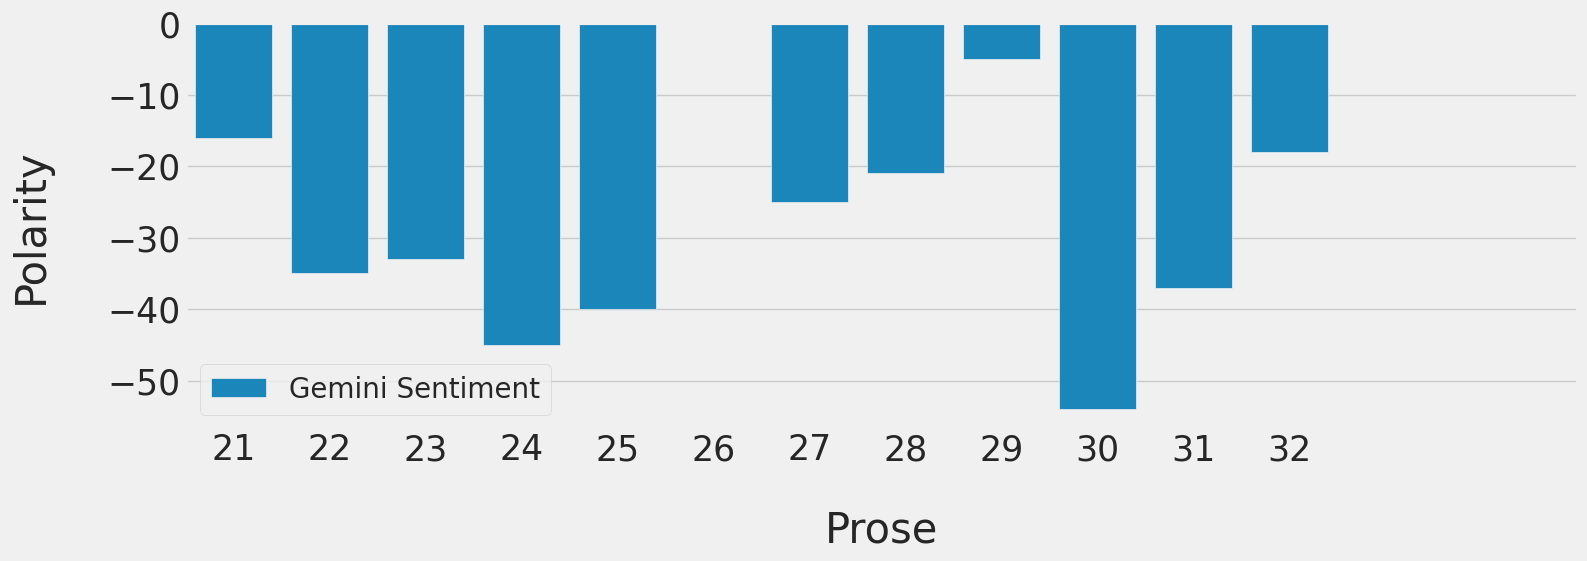

In [62]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Prose', 'Polarity'])

for prose in prose_names:
    df_prose = pd.read_csv('results/prose/sentiment/' + 'gem/' + prose)
    polarity = 0
    for i, row in df_prose.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[prose[:2], polarity]], columns = ['Prose', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Prose')
df_sentiments.reset_index()
df_sentiments.set_index('Prose')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Prose'], y=df_sentiments['Polarity'], label='Gemini Sentiment')
p6.set_xlabel("Gemini Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Prose', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

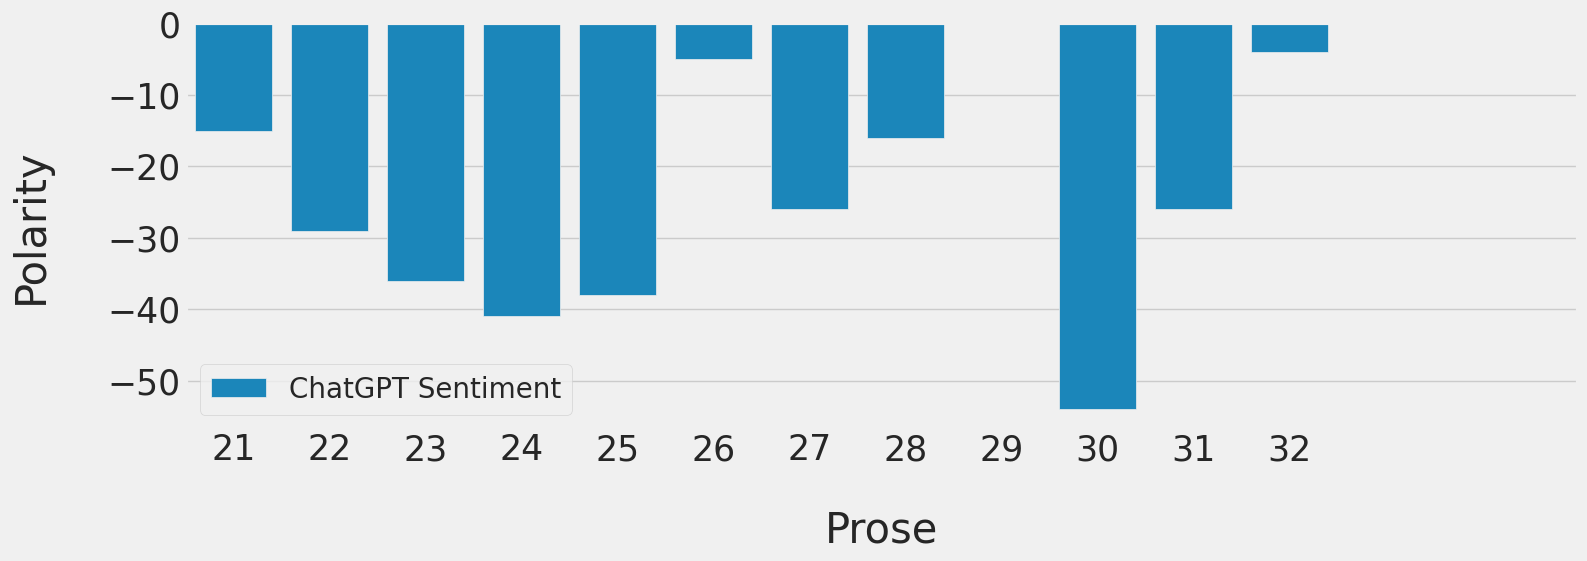

In [64]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Prose', 'Polarity'])

for prose in prose_names:
    df_prose = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)
    polarity = 0
    for i, row in df_prose.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[prose[:2], polarity]], columns = ['Prose', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Prose')
df_sentiments.reset_index()
df_sentiments.set_index('Prose')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Prose'], y=df_sentiments['Polarity'], label='ChatGPT Sentiment')
p6.set_xlabel("ChatGPT Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Prose', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

In [65]:
topic_df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for prose in prose_names[1:]:
    df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)
    topic_df = pd.concat([topic_df, df], axis=0)

topic_df.head()

Tweet  \
0                                                                                                                                                                                                                         I have come to the dense forest...   
1                                                                                         As long as I am alive, I will grace the forest, the grass, and that rough cliff watching from afar with my beauty. I will spread my fragrance to the surroundings.   
2  Everyone loves me: look at that rotting stump, its eyes always fixed on me, it smiles sometimes, wanting to come closer, to kiss me, but it cannot; it only smiles at me from a distance, poor thing, though unattractive, a great kindness spreads ov...   
3                                                                                                                                                                                                                 Is it only that which rejoices in my life?   
4                                                                                             Even the dead trees support me from above, themselves bare-headed, they cover me with their branches: "Let our violet not get cold, or be harmed by anything."   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         0.0       0.0         0.0          0.0      0.0  1.0      0.0   
3         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
4         0.0       0.0         1.0          0.0      1.0  0.0      0.0   

   Denial  Joking  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     1.0  
3     0.0     0.0  
4     0.0     1.0

In [66]:
stop_words = stopwords.words('english')
newStopWords = []
stop_words.extend(newStopWords)

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)                                   # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
    return ngrams_series

In [67]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth": 1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center=90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center=0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center=9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [68]:
len(stop_words)

179

In [69]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0                                                                                                                                                                               have come dense forest   
1                                                                                long alive will grace forest grass that rough cliff watching from afar with beauty will spread fragrance surroundings   
2  everyone loves look that rotting stump eyes always fixed smiles sometimes wanting come closer kiss cannot only smiles from distance poor thing though unattractive great kindness spreads over face   
3                                                                                                                                                                        only that which rejoices life   
4                                                                                 even dead trees support from above themselves bare headed they cover with their branches violet cold harmed anything   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         0.0       0.0         0.0          0.0      0.0  1.0      0.0   
3         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
4         0.0       0.0         1.0          0.0      1.0  0.0      0.0   

   Denial  Joking  \
0     0.0     0.0   
1     0.0     0.0   
2     0.0     1.0   
3     0.0     0.0   
4     0.0     1.0   

                                                                                                                                                                                                                        Tweet tokens  \
0                                                                                                                                                                                                        [have, come, dense, forest]   
1                                                                                           [long, alive, will, grace, forest, grass, that, rough, cliff, watching, from, afar, with, beauty, will, spread, fragrance, surroundings]   
2  [everyone, loves, look, that, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, only, smiles, from, distance, poor, thing, though, unattractive, great, kindness, spreads, over, face]   
3                                                                                                                                                                                                [only, that, which, rejoices, life]   
4                                                                                            [even, dead, trees, support, from, above, themselves, bare, headed, they, cover, with, their, branches, violet, cold, harmed, anything]   

                                                                                                                                                                                              tokens_no_stop  \
0                                                                                                                                                                                      [come, dense, forest]   
1                                                                                                 [long, alive, grace, forest, grass, rough, cliff, watching, afar, beauty, spread, fragrance, surroundings]   
2  [everyone, loves, look, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, smiles, distance, poor, thing, though, unattractive, great, kindness, spreads, face]   
3                                                                                                                                                                                

In [70]:
text = retrieve_text(topic_df)
text.split('. ')

['come dense forest',
 'long alive grace forest grass rough cliff watching afar beauty spread fragrance surroundings',
 'everyone loves look rotting stump eyes always fixed smiles sometimes wanting come closer kiss cannot smiles distance poor thing though unattractive great kindness spreads face',
 'rejoices life',
 'even dead trees support bare headed cover branches violet cold harmed anything',
 'heavy rain reach directly rain strip leaves',
 'without leaves death',
 'trees birch beech hazel poplar surround guard keep rain moisture branches leaves slowly drip onto washing face',
 'lift head wish could sing creator given gift praise high clouds protective trees mountains meadows chirping birds green feathers dance yellow leaves sometimes chirp play rejoicing life',
 'month life better someone else twenty four months life long long life',
 'morning beech bird sang near beautiful throated chirping like admired looking chest shoulders everyone admires everyone rejoices life everyone love

Text(0, 0.5, '')

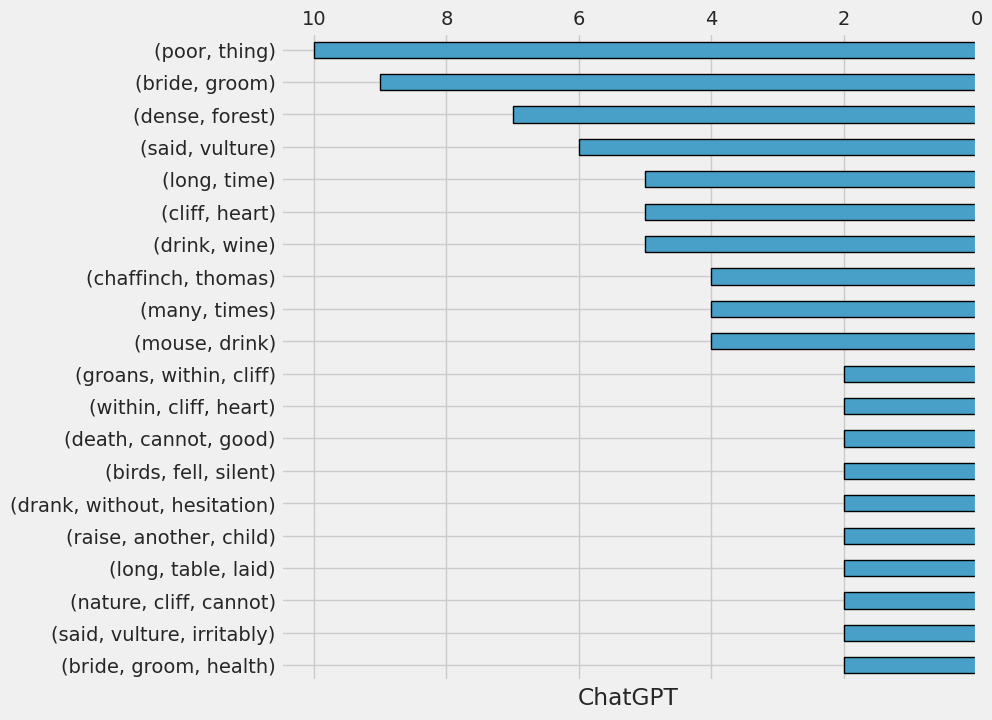

In [71]:
bigram1 = ngrams_series_func(text, 2)
trigram1 = ngrams_series_func(text, 3)
ngram1 = pd.concat([bigram1, trigram1])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,1, figsize=(8,8))
barh_ax = ax

ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('ChatGPT')
barh_ax.set_ylabel('', fontsize=50)

In [72]:
topic_df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for prose in prose_names[1:]:
    df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)
    topic_df = pd.concat([topic_df, df], axis=0)

In [73]:
stop_words = stopwords.words('english')

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)                                   # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
    return ngrams_series

In [74]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)


In [75]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0                                                                                                                                                                               have come dense forest   
1                                                                                long alive will grace forest grass that rough cliff watching from afar with beauty will spread fragrance surroundings   
2  everyone loves look that rotting stump eyes always fixed smiles sometimes wanting come closer kiss cannot only smiles from distance poor thing though unattractive great kindness spreads over face   
3                                                                                                                                                                        only that which rejoices life   
4                                                                                 even dead trees support from above themselves bare headed they cover with their branches violet cold harmed anything   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         0.0       0.0         0.0          0.0      0.0  1.0      0.0   
3         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
4         0.0       0.0         1.0          0.0      1.0  0.0      0.0   

   Denial  Joking  \
0     0.0     0.0   
1     0.0     0.0   
2     0.0     1.0   
3     0.0     0.0   
4     0.0     1.0   

                                                                                                                                                                                                                        Tweet tokens  \
0                                                                                                                                                                                                        [have, come, dense, forest]   
1                                                                                           [long, alive, will, grace, forest, grass, that, rough, cliff, watching, from, afar, with, beauty, will, spread, fragrance, surroundings]   
2  [everyone, loves, look, that, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, only, smiles, from, distance, poor, thing, though, unattractive, great, kindness, spreads, over, face]   
3                                                                                                                                                                                                [only, that, which, rejoices, life]   
4                                                                                            [even, dead, trees, support, from, above, themselves, bare, headed, they, cover, with, their, branches, violet, cold, harmed, anything]   

                                                                                                                                                                                              tokens_no_stop  \
0                                                                                                                                                                                      [come, dense, forest]   
1                                                                                                 [long, alive, grace, forest, grass, rough, cliff, watching, afar, beauty, spread, fragrance, surroundings]   
2  [everyone, loves, look, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, smiles, distance, poor, thing, though, unattractive, great, kindness, spreads, face]   
3                                                                                                                                                                                

In [76]:
df_optimistic = topic_df[topic_df['Optimistic'] == 1]
df_pessimistic = topic_df[topic_df['Pessimistic'] == 1]
df_denial = topic_df[topic_df['Denial'] == 1]
df_annoyed = topic_df[topic_df['Annoyed'] == 1]
df_thankful = topic_df[topic_df['Thankful'] == 1]
df_empathetic = topic_df[topic_df['Empathetic'] == 1]
df_anxious = topic_df[topic_df['Anxious'] == 1]
df_sad =  topic_df[topic_df['Sad'] == 1]
df_joking = topic_df[topic_df['Joking'] == 1]

In [77]:
text_optimistic = '. '.join(df_optimistic.tokens_no_stop_joined)
text_pessimistic = '. '.join(df_pessimistic.tokens_no_stop_joined)
text_denial = '. '.join(df_denial.tokens_no_stop_joined)
text_annoyed = '. '.join(df_annoyed.tokens_no_stop_joined)
text_thankful = '. '.join(df_thankful.tokens_no_stop_joined)
text_empathetic = '. '.join(df_empathetic.tokens_no_stop_joined)
text_anxious = '. '.join(df_anxious.tokens_no_stop_joined)
text_sad = '. '.join(df_sad.tokens_no_stop_joined)
text_joking = '. '.join(df_joking.tokens_no_stop_joined)

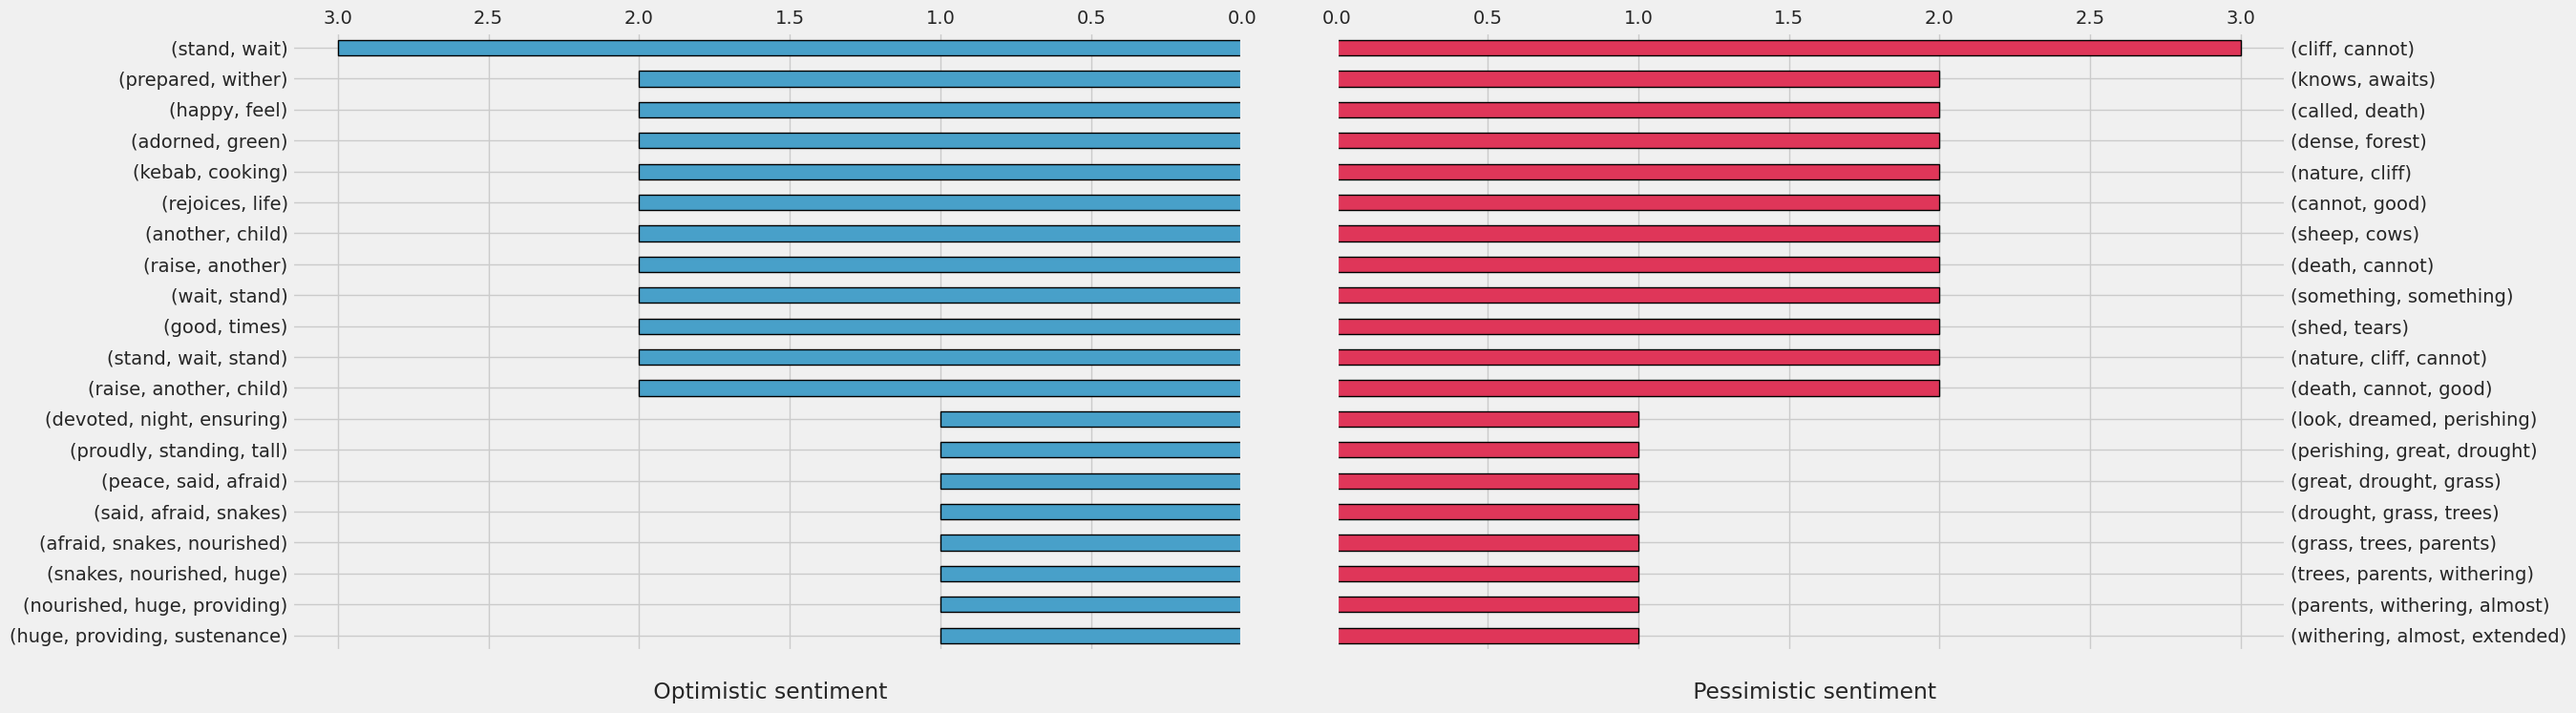

In [78]:
bigram1 = ngrams_series_func(text_optimistic, 2)
trigram1 = ngrams_series_func(text_optimistic, 3)
bigram2 = ngrams_series_func(text_pessimistic, 2)
trigram2 = ngrams_series_func(text_pessimistic, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1, 2, figsize=(24, 8), gridspec_kw = {'width_ratios':[1,1], 'wspace': 0.1, 'hspace': 0.1})

barh_ax = ax[0]
ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Optimistic sentiment')
barh_ax.set_ylabel('',fontsize=50)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Pessimistic sentiment')
plt.show()

In [79]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']

def return_sentiments(data, row):
    text = ''
    for sentiment in sentiments:
        if data[sentiment][row] == 1:
            text += sentiment
            text += ', '
    return text

In [81]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']
data = pd.DataFrame(columns=[
    'Prose', 'Verse No.', 'Author', 'Verse', 'Predicted Sentiments', 
    'Hewitt - Google', 'Hewitt - Gemini', 'Hewitt - ChatGPT'
])
count = 0

for prose in prose_names:
    semantic_comparsion = pd.read_csv('results/prose/similarity/cosine_similarity.csv')
    
    df_ggl = pd.read_csv('results/prose/sentiment/' + 'ggl/' + prose)
    df_ggl = df_ggl.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gem = pd.read_csv('results/prose/sentiment/' + 'gem/' + prose)
    df_gem = df_gem.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gpt = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)
    df_gpt = df_gpt.drop(['Unnamed: 0', 'Official report'], axis=1)

    for ii in range(3 * df_ggl.shape[0]):
        
        if ii % 3 == 0:
            pr_sentiments = return_sentiments(df_ggl, ii // 3)
            dict2 = {
                'Prose': [prose], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['Google'],
                'Verse': [df_ggl['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [semantic_comparsion['Hewitt - Google'][ii // 3]], 
                'Hewitt - Gemini': [semantic_comparsion['Hewitt - Gemini'][ii // 3]],
                'Hewitt - ChatGPT': [semantic_comparsion['Hewitt - ChatGPT'][ii // 3]]
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        elif ii % 3 == 1:
            pr_sentiments = return_sentiments(df_gem, ii // 3)
            dict2 = {
                'Prose': [' '], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['Gemini'], 
                'Verse': [df_gem['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - ChatGPT': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        else:
            pr_sentiments = return_sentiments(df_gpt, ii // 3)
            dict2 = {
                'Prose': [' '], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['ChatGPT'], 
                'Verse': [df_gpt['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - ChatGPT': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data=pd.concat([data, df_temp], ignore_index=True)

data

Prose Verse No.   Author  \
0                      21_violet.md         1   Google   
1                                           1   Gemini   
2                                           1  ChatGPT   
3                      21_violet.md         2   Google   
4                                           2   Gemini   
...                             ...       ...      ...   
2758                                      158   Gemini   
2759                                      158  ChatGPT   
2760  32_the_wedding_of_the_jays.md       159   Google   
2761                                      159   Gemini   
2762                                      159  ChatGPT   

                                                                                                                                                                                           Verse  \
0                                                                                                                                                             I have come to the dense forest...   
1                                                                                                                                                               I have come to a dense forest...   
2                                                                                                                                                             I have come to the dense forest...   
3                                                    As long as I am alive, I will sweeten the forest, the grass, and the mossy rock with my beauty, I will sprinkle spices on the surroundings.   
4                                As long as I am alive, I will delight the forest, the grass, and that heart-shaped rock looking at me from afar with my beauty, I will spread fragrance around.   
...                                                                                                                                                                                          ...   
2758                                                                                               The eagle itself took flight, soaring high as if touching the sky, and began to circle above.   
2759                                                                                                                         Then he flew up, as if to pierce the sky, and began circling above.   
2760  Ketevan and Zakara also took shelter in the dense forest: they spent that day hugging and kissing each other, and in the evening they slept side by side on the beech branch of the other.   
2761              Ketevan and Zakara also sought refuge in the dense forest, spending the day and evening in each other's embrace. They fell asleep side by side on a branch of a hornbeam tree.   
2762          Ketevan and Zakara retreated into the dense forest: they spent the day in each other’s arms, kissing and embracing, and fell asleep side by side on a beech branch in the evening.   

      Predicted Sentiments Hewitt - Google Hewitt - Gemini Hewitt - ChatGPT  
0       Pessimistic, Sad,         0.802988        0.827873         0.802988  
1       Pessimistic, Sad,                                                    
2       Pessimistic, Sad,                                                    
3     Optimistic, Joking,         0.831107        0.876884         0.846976  
4     Optimistic, Joking,                                                    
...                    ...             ...             ...              ...  
2758              Joking,                                                    
2759              Joking,                                                    
2760              Joking,         0.669401        0.669401         0.695002  
2761     Empathetic, Sad,                                                    
2762         Sad, Joking,                                                    

[2763 rows x 8 columns]